In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
#%cd /gdrive/My\ Drive

Mounted at /gdrive


In [ ]:
import pickle
import numpy as np
import pandas as pd
arr = []
for i in ['inp_data', 'out_data', 'drop_desc', 'Afr_inp_data', 'Afr_out_data']:
  file_name = i + '.pkl'
  arr.append(pickle.load(open(r'/gdrive/My Drive/'+file_name,'rb')))

#dicts to store accuracy and false positive for base dataset
base_acc = {}
base_fp = {}

#dicts to store accuracy and false positive for race_specific_dataset
race_specific_acc = {}
race_specific_fp = {}

#cols store the column features of the input dataset
cols = arr[0].columns

#Datasets are stored in dataframes from the array
inp_data = arr[0]
out_data = arr[1]

drop_desc = arr[2]

Afr_inp_data = arr[3]
Afr_out_data = arr[4]

inp_data.shape

(10598, 185)

Both the pickled dataframes inp_data, out_data are retrieved from the google drive and converted to numpy array using to_numpy() function.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
import joblib

All the necessary libraries of sklearn for support vector machine and performance metrics are imported in the above cell.

In [ ]:
def data_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.20, random_state=42, stratify = y.to_numpy())
    return X_train, X_test, y_train, y_test

The loaded datasets are divided into training and test set using train_test_split functiion and is stratified over output_label in order to have equal proportion of both the classes in training and test set. 

In [ ]:
def parameter(clf):
  '''The function chooses the set of parameters to be passed according to the classifier used'''
  
  #If the classifier is support vector machine
  if clf == 'SVM':
    parameters = [
        
            {
              "kernel": ["rbf"],
              "C": [0.1, 0.5, 1, 5],
              "gamma": [0.01, 0.05, 0.1]
            }
        ]

  #If the classifier is Random forest
  elif clf == 'RF':
    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 40, num = 5)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]

    parameters = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
                   
  #If the classifier is Multiple layer perceptron
  elif clf == 'MLP':
    parameters = {
      'hidden_layer_sizes': [(20,)],
      'activation': ['logistic', 'relu'],
      'solver': ['adam', 'lbfgs', 'sgd'],
      'alpha': [int(x) for x in np.linspace(10, 110, num = 5)],
      'learning_rate': ['constant','adaptive'],
      }
  return parameters

Parameters for GridsearchCV are defined here both values of C nad Gamma are uniformly spaced as multiples of 5.

In [ ]:
def svm_classifier(X_train, X_test, y_train, y_test, parameters):
  '''The following function when called will perform an exhaustive search 
      over all the para,eters to find the set of parameters which give 
      the best fit of parameters with lowest cross validation error'''
  svm = SVC(probability = True)

  print("finding best value for C and gamma")
  print("################")

  #Finding best parameters C and gamma using GridserchCV

  clf = GridSearchCV(svm, param_grid = parameters,  cv=5, n_jobs=-1, verbose=2, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel())
  ypred = clf.predict(X_test)

  tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
  
  disp = plot_confusion_matrix(clf, X_test, y_test.ravel(),
                                 cmap=plt.cm.Blues, normalize='true')
  tuned_clf = clf.best_estimator_
  disp.ax_.set_title('Confusion matrix')
  print("###################")
  print()
  acc = clf.score(X_test,y_test.ravel())
  print("Accuracy is", acc)
  print("###################")
  print()
  print(classification_report(y_test, ypred))
  return tuned_clf, ypred, acc, fp

A function svm_classifier() is defined to create a classifier which runs over all the possible combinations of the parameters mentioned in parameters dictionary using GridSearchCV to select the best parameters and fit the training set **X_train** using the best parameters found andalso returns a confusion matrix for the test set.

In [ ]:
def Random_forest_clf(X_train, X_test, y_train, y_test, parameters):
  '''The following function uses random forest classifier and GridsearchCV to find
     the best fit for the parameters and plot confusion matrix for the test '''
     
  rfc = RandomForestClassifier()
  clf = GridSearchCV(rfc, param_grid = parameters,  cv=3, n_jobs=-1, verbose=2, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel())
  ypred = clf.predict(X_test)
  y_predprob = clf.predict_proba(X_test)

  tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
  disp = plot_confusion_matrix(clf, X_test, y_test.ravel(),
                                 cmap=plt.cm.Blues, normalize = 'true')
  
  tuned_clf = clf.best_estimator_
  disp.ax_.set_title('Confusion matrix')
  print("###################")
  print()
  acc = clf.score(X_test,y_test.ravel())
  print("Accuracy is", acc)
  print("###################")
  print()
  print(classification_report(y_test, ypred))
  return tuned_clf, ypred, acc, fp

In [ ]:
def mlp_clf(X_train, X_test, y_train, y_test, parameters):
  mlp = MLPClassifier(max_iter = 3500)
  clf = GridSearchCV(mlp, param_grid = parameters,  cv=3, n_jobs=-1, verbose=0.5, refit = 'precision_weighted')
  clf.fit(X_train, y_train.ravel())
  ypred = clf.predict(X_test)

  tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
  disp = plot_confusion_matrix(clf, X_test, y_test.ravel(),
                                 cmap=plt.cm.Blues, normalize = 'true')
  tuned_clf = clf.best_estimator_
  disp.ax_.set_title('Confusion matrix')
  print("###################")
  print()
  acc = clf.score(X_test,y_test.ravel())
  print("Accuracy is", acc)
  print("###################")
  print()
  print(classification_report(y_test, ypred))
  return tuned_clf, ypred, acc, fp

In [ ]:
def plot_learning_curve(classifier, X, y):
  '''The following function is used to plot the learning curve for both training and cross-validation accuracy 
  for differnt number of training examples to find if the model is under-fitting or over-fitting'''

  plt.figure()
  plt.style.use(['ggplot'])
  plt.title("Learning curve")
  train_sizes, train_acc, test_acc = learning_curve(
        classifier, X, y, n_jobs=-1, shuffle = True, train_sizes=np.linspace(.1, 1.0, 10))
  
  train_acc_mean = np.mean(train_acc, axis=1)
  train_acc_std = np.std(train_acc, axis=1)
  test_acc_mean = np.mean(test_acc, axis=1)
  test_acc_std = np.std(test_acc, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_acc_mean - train_acc_std,
                     train_acc_mean + train_acc_std, alpha=0.1,
                     color="r")
  plt.fill_between(train_sizes, test_acc_mean - test_acc_std,
                     test_acc_mean + test_acc_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_acc_mean, 'o-', color="r",
             label="Training accuracy")
  plt.plot(train_sizes, test_acc_mean, 'o-', color="g",
             label="Cross-validation accuracy")

  plt.legend(loc="best")
  plt.show()

In [ ]:
def call_classifier(inp_data, out_data, clf):
  if clf == 'svm':
    parameters = parameter('SVM')
    X_train, X_test, y_train, y_test = data_split(inp_data, out_data)
    tuned_clf, ypred, acc, fp = svm_classifier(X_train, X_test, y_train, y_test, parameters)
  elif clf == 'rf':
    parameters = parameter('RF')
    X_train, X_test, y_train, y_test = data_split(inp_data, out_data)
    tuned_clf, ypred, acc, fp = Random_forest_clf(X_train, X_test, y_train, y_test, parameters)
  elif clf == 'mlp':
    parameters = parameter('MLP')
    X_train, X_test, y_train, y_test = data_split(inp_data, out_data)
    tuned_clf, ypred, acc, fp = mlp_clf(X_train, X_test, y_train, y_test, parameters)

  #plot_learning_curvefunction is called and tuned_clf, X_train, y_train are passed as parameters

  plot_learning_curve(tuned_clf, X_train, y_train)

  #wil plot the ROC curve for svm classifier havimg false positive rate on x-axis and true positive rate on y-axis

  plt.style.use(['ggplot'])
  plot_roc_curve(tuned_clf, X_test, y_test)
  plt.show()
  return acc, fp

# Base Dataset

## **Support Vector Machine**

finding best value for C and gamma
################
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 42.4min finished


###################

Accuracy is 0.7075471698113207
###################

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1370
           1       0.63      0.41      0.50       750

    accuracy                           0.71      2120
   macro avg       0.68      0.64      0.65      2120
weighted avg       0.70      0.71      0.69      2120



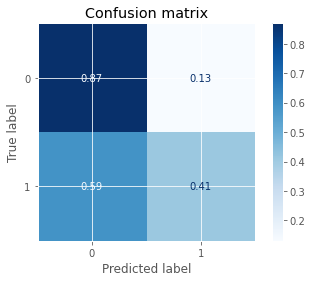

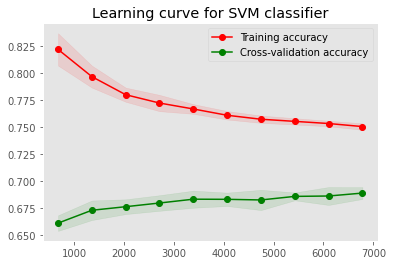

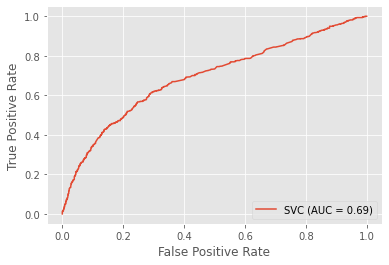

In [ ]:
acc, fp = call_classifier(inp_data, out_data, 'svm')
base_acc['svm'] = acc
base_fp['svm'] = fp

1. From the learning curve it is depicted that the model is overfitting, due to unavailability of more data attempts must be made to simplify the model or remove further noise from the data to increase accuracy of the model.

2. And the area under the ROC curve is 0.69 

## **Multiple Layer Perceptron**

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.6min finished


###################

Accuracy is 0.7033018867924529
###################

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1370
           1       0.63      0.39      0.48       750

    accuracy                           0.70      2120
   macro avg       0.68      0.63      0.64      2120
weighted avg       0.69      0.70      0.68      2120



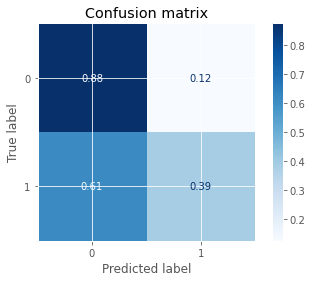

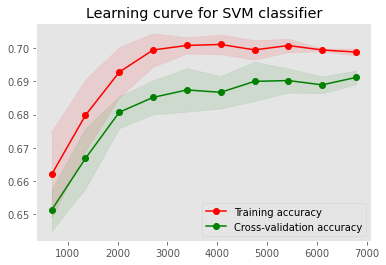

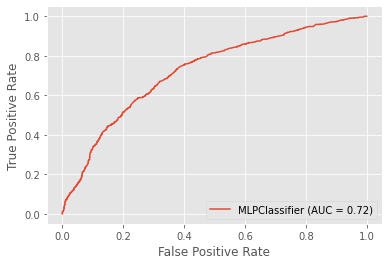

In [ ]:
acc, fp = call_classifier(inp_data, out_data, 'mlp')
base_acc['mlp'] = acc
base_fp['mlp'] = fp

1. Unlike other models Multiple Layer Perceptron does not overfit the dataset 
2. It also produces a better ROC AUC curve with an area of 0.72
3. There is also a decrease in the false positive rate as compared to Support Vector Machine from 0.13 to 0.12

## **Random Forest Classifier**

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 22.9min finished


###################

Accuracy is 0.6971698113207547
###################

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      1370
           1       0.63      0.34      0.45       750

    accuracy                           0.70      2120
   macro avg       0.67      0.62      0.62      2120
weighted avg       0.68      0.70      0.67      2120



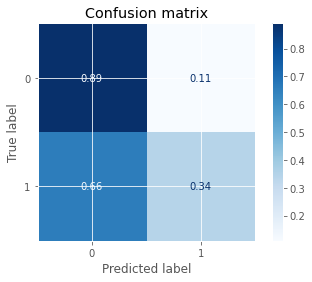

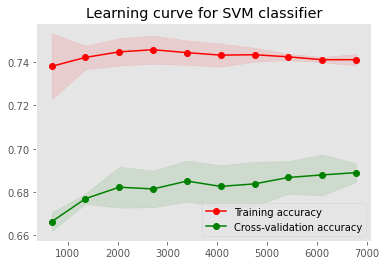

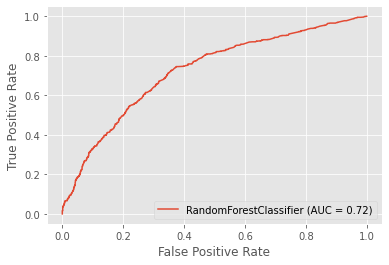

In [ ]:
acc, fp = call_classifier(inp_data, out_data, 'rf')
base_acc['rf'] = acc
base_fp['rf'] = acc

1. As depicted from Confusion matrix there is a significant decrease in the false positive rate making Random Forest Classifier the best performer in terms of false positive rate.

2. There is a compromise in the accuracy of the model which is 0.69 which might be due to the unbalanced classes in the dataset.

3. Area under the ROC curve is 0.69.

# Race Specific Dataset

## **Support Vector Machine**

finding best value for C and gamma
################
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.9min finished


###################

Accuracy is 0.6816479400749064
###################

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       623
           1       0.64      0.54      0.58       445

    accuracy                           0.68      1068
   macro avg       0.67      0.66      0.66      1068
weighted avg       0.68      0.68      0.68      1068



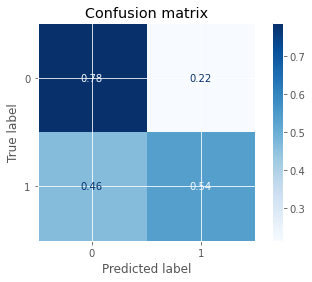

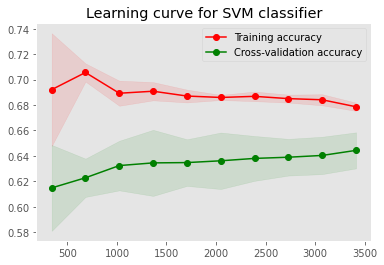

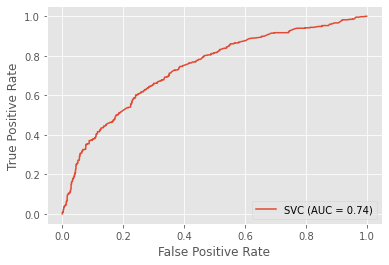

In [ ]:
acc, fp = call_classifier(Afr_inp_data, Afr_out_data, 'svm')
race_specific_acc['svm'] = acc
race_specific_fp['svm'] = fp

Judging the models on the basis of accuracy would not be a great idea as the number of data samples are less as compared to the base dataset. Therefore, to make a better judgement ROC curves are used to compare the models.

## **Random Forest Classifier**

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 12.5min finished


###################

Accuracy is 0.6685393258426966
###################

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       623
           1       0.64      0.46      0.53       445

    accuracy                           0.67      1068
   macro avg       0.66      0.64      0.64      1068
weighted avg       0.66      0.67      0.66      1068



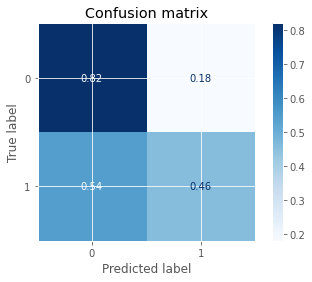

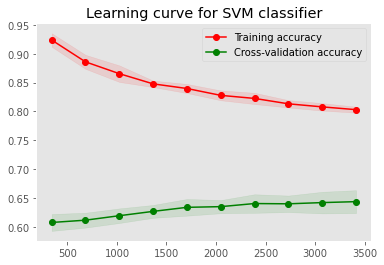

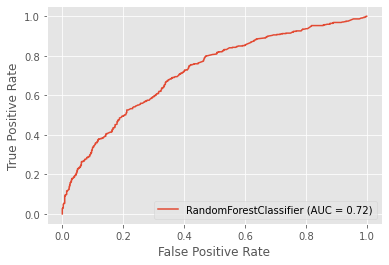

In [ ]:
acc, fp = call_classifier(Afr_inp_data, Afr_out_data, 'rf')
race_specific_acc['rf'] = acc
race_specific_fp['rf'] = fp

## **Multiple Layer Perceptron**

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.8min finished


###################

Accuracy is 0.6919475655430711
###################

              precision    recall  f1-score   support

           0       0.70      0.84      0.76       623
           1       0.68      0.49      0.57       445

    accuracy                           0.69      1068
   macro avg       0.69      0.66      0.66      1068
weighted avg       0.69      0.69      0.68      1068



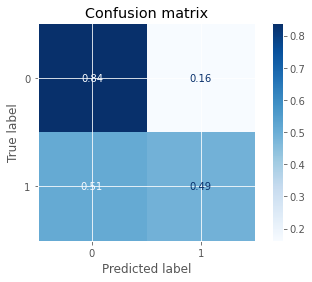

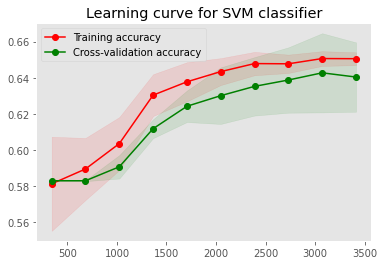

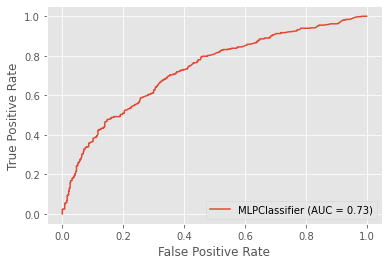

In [ ]:
acc, fp = call_classifier(Afr_inp_data, Afr_out_data, 'mlp')
race_specific_acc['mlp'] = acc
race_specific_fp['mlp'] = fp

In case of Race-specific dataset SVM turns out to be the best classifier as it had the highest score for "Area under ROC curve" of **0.74** which is higher than it's performance in base dataset of **0.72**



# Visualizing Results

## **Comparing Accuracy**

In [ ]:
model, acc1 = zip(*base_acc.items())
model, acc2 = zip(*race_specific_acc.items())
model = list(model)
acc1 = list(acc1)
acc2 = list(acc2)

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

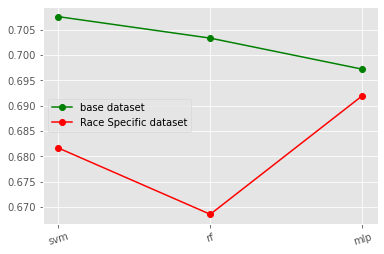

In [ ]:
plt.style.use(['ggplot'])
plt.tight_layout()
plt.plot(model, acc1, 'o-', label = 'base dataset', color = 'g')
plt.plot(model, acc2, 'o-', label = 'Race Specific dataset', color = 'r')
plt.legend(loc="best")
plt.xticks(rotation=17)

From the above graph it is depicted that SVM gave the best accuracy for the base dataset whereas in Race-specific datasets MLP was the best classifier.

The reason for a low accuracy in the case of Race-specific dataset is beacause of less number of data samples.

## **Comparing False Positive Rate**

In [ ]:
model, fp1 = zip(*base_fp.items())
model, fp2 = zip(*race_specific_fp.items())
model = list(model)
fp1 = list(fp1)
fp2 = list(fp2)

([0, 1, 2], <a list of 3 Text major ticklabel objects>)

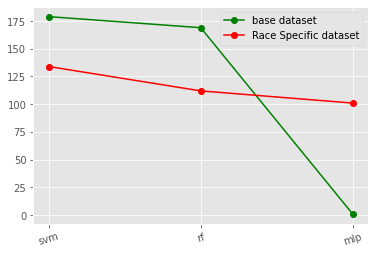

In [ ]:
plt.style.use(['ggplot'])
plt.tight_layout()
plt.plot(model, fp1, 'o-', label = 'base dataset', color = 'g')
plt.plot(model, fp2, 'o-', label = 'Race Specific dataset', color = 'r')
plt.legend(loc="best")
plt.xticks(rotation=17)

Judging models only on the basis of accuracy would not be enough as the classes of the dataset are not balanced. 

On both base and race-specific datasets MLP had the least false-positive rate. 

# Most Important Features

In [ ]:
#TODO: 1. Convert X_train from NumPy to Dataframe
#      2. Store importance of each feature into feature_score

X_train = pd.DataFrame(X_train, columns=[cols])
feature_scores = pd.Series(tuned_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [ ]:
feature_scores.head(10)

priors_count_0                       0.123695
priors_count_1                       0.058602
age_cat_Greater than 45              0.045085
age_cat_Less than 25                 0.041252
juv_misd_count_0                     0.035116
juv_other_count_0                    0.028729
priors_count_2                       0.027492
c_charge_desc_Possession of drugs    0.024682
c_charge_degree_(F3)                 0.024011
age_cat_25 - 45                      0.022480
dtype: float64

In [ ]:
#TODO: Create and store list of names of features and their score

feature_name = feature_scores.index.tolist()
feature_count = feature_scores.values.tolist()

In [ ]:
feature_name = [item for i in feature_name for item in i]

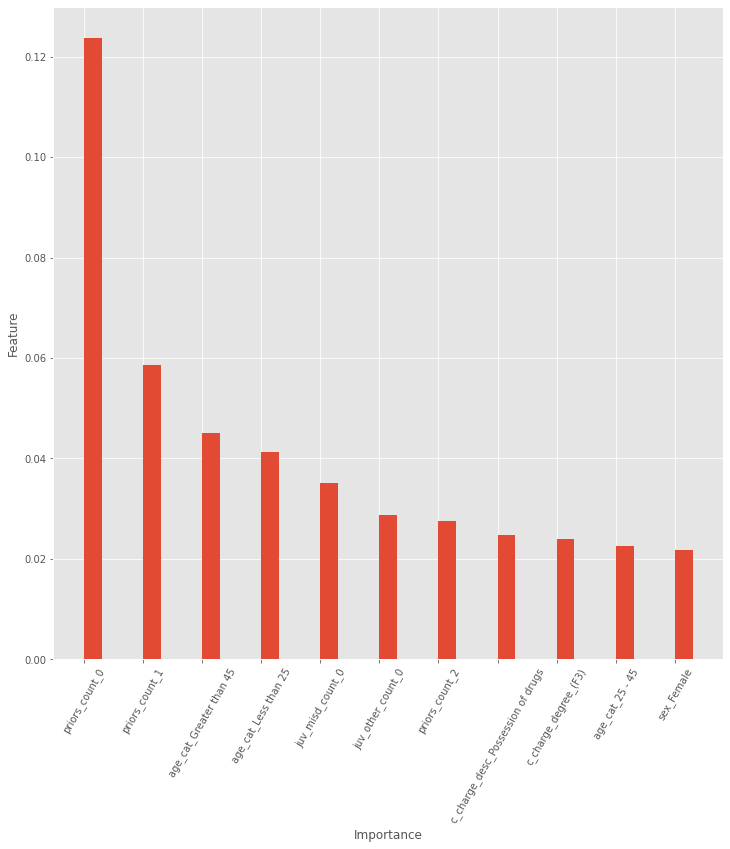

In [ ]:
#TODO: Visualize the feature importance using bar graph

plt.style.use(['ggplot'])
plt.figure(figsize=(12, 12))
plt.bar(feature_name[0:11], feature_count[0:11], width=0.3, align='edge')
plt.xticks(rotation=60) 
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

From the above graph it is depicted that the most deciding features in case of Random forest are:

1. Prior_counts
2. juv_misd_count
3. juv_other_count
4. age_cat
5. sex

The following features will be further explored to understand the racial bias in the dataset in the notebook: "Bias_Analysis".